In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.constants import e
from tqdm.auto import tqdm
import pdb
%config InlineBackend.figure_formats = ['svg']

# Pulse shape model

In [2]:
# def det_2comp(t, T, C, Gb, Tb, G, P, t0):
#     matrix = np.array([
#         [(G[0,1] + Gb[0]) / C[0], -G[0,1] / C[0]],
#         [-G[0,1] / C[1], (G[0,1] + Gb[1]) / C[1]]
#     ])
#     P_ = P(t, t0)
#     rhs = np.array([P_[0] / C[0], P_[1] / C[1]])
#     d_delta_T_dt = rhs - matrix.dot(T)
#     return d_delta_T_dt

def det(t, T, C, Gb, Tb, G, P, t0):
    
    dT = P(t, t0)  # heat input
    dT += Gb * (Tb - T)  # coupling to temperature bath
    dT += np.dot(G, T)  # heat transfer from other components
    dT -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
    dT /= C  # heat to temperature

    return dT

In [3]:
C = np.array([1e-2, 
              3.8-2])  # pJ/mK
Gb = np.array([2.,
               5.]) # heat cond to bath, pW/mK
Tb = np.array([0., 0.])  # temp bath
G_ea = 1e-6  # pW/mK
G = np.array([[0., G_ea], 
              [G_ea, 0.], ])  # heat cond between components
lamb = 0.01  # thermalization time, s
eps = .05  # share in thermometer
eps_ = np.array([eps, 
                 (1-eps)])
delta = 0.  # share in thermometer
delta_ = np.array([delta, 
                 (1-delta)])

record_window = 16384
sample_frequency = 25000
t0 = record_window/sample_frequency/8  # onset time, s
er = 1.  # pJ

def P_particle(x, t0):
    if t0 < x:
        retv = er*eps_*np.exp(-(x-t0)/lamb)/lamb 
    else:
        retv = np.zeros(eps_.shape)
    return retv  # pW

t = np.arange(0,record_window/sample_frequency,1/sample_frequency,)  # s

T0 = Tb * np.ones(C.shape[0])  # mK

time_step = t[1] - t[0]

In [4]:
%time Tp = odeint(det, T0, t, args=(C, Gb, Tb, G, P_particle, t0), tfirst=True)#, tcrit=np.arange(t0 - 3 * time_step, t0 + lamb*10, time_step))  # particle

CPU times: user 17.4 ms, sys: 6.18 ms, total: 23.6 ms
Wall time: 18.5 ms


In [5]:
# %time Tp_2comp = odeint(det_2comp, T0, t, args=(C, Gb, Tb, G, P_particle, t0), tfirst=True)#, tcrit=np.arange(t0 - 3 * time_step, t0 + lamb*10, time_step))  # particle

In [6]:
tau_n = lamb
G_eb = Gb[0]
G_ab = Gb[1]
C_e = C[0]
C_a = C[1]

a = (G_ea + G_eb) / C_e + (G_ea + G_ab) / C_a
b = (G_ea * G_eb + G_ea * G_ab + G_eb * G_ab) / (C_e * C_a)

tau_in = 2 / (a + np.sqrt(a**2 - 4 * b))
tau_t = 2 / (a - np.sqrt(a**2 - 4 * b))
s_in = 1 / tau_in
s_t = 1 / tau_t
s_n = 1 / tau_n

P_0 = eps * er / tau_n

A_n = (P_0 * (s_in - (G_ab / C_a))) 
A_n /= (eps * (s_in - s_t) * (s_in - s_n)) 
A_n *= ((s_t - (G_ab / C_a)) / (G_eb - (C_e / C_a) * G_ab) - (eps / C_e))

A_t = (P_0 * (s_t - (G_ab / C_a))) 
A_t /= (eps * (s_t - s_in) * (s_t - s_n))
A_t *= ((s_in - (G_ab / C_a)) / (G_eb - (C_e / C_a) * G_ab) - (eps / C_e))

alpha_in = 1 + G_ab / G_ea - s_in * C_a / G_ea
alpha_t = 1 + G_ab / G_ea - s_t * C_a / G_ea

A_n_me = (er / tau_n)  
A_n_me /= (1 - alpha_t / alpha_in)
A_n_me *= (alpha_t * (1 - eps) / C_a - eps / C_e)
A_n_me /= (1 / tau_n - 1 / tau_in)

A_t_me = (-er / tau_n) 
A_t_me /= (1 - alpha_in / alpha_t) 
A_t_me *= (alpha_in * (1 - eps) / C_a - eps / C_e) 
A_t_me *= (1 / tau_n - 1 / tau_t)**(-1)

A_n_abs_me = A_n_me / alpha_in
A_t_abs_me = A_t_me / alpha_t

coeff = A_n * (np.exp(-(t - t0) / tau_n) - np.exp(-(t - t0) / tau_in)) + A_t * (np.exp(-(t - t0) / tau_t) - np.exp(-(t - t0) / tau_n))
dTe_Franz = np.heaviside(t - t0, 1)*coeff

coeff_me = A_n_me * (np.exp(-(t - t0) / tau_n) - np.exp(-(t - t0) / tau_in)) + A_t_me * (np.exp(-(t - t0) / tau_t) - np.exp(-(t - t0) / tau_n))
dTe_me = np.heaviside(t - t0, 1)*coeff_me

coeff_abs_me = A_n_abs_me * (np.exp(-(t - t0) / tau_n) - np.exp(-(t - t0) / tau_in)) + A_t_abs_me * (np.exp(-(t - t0) / tau_t) - np.exp(-(t - t0) / tau_n))
dTa_me = np.heaviside(t - t0, 1)*coeff_abs_me

In [7]:
print(tau_n, tau_in, tau_t)

0.01 0.004999997500001243 0.35999992800004976


In [8]:
print(alpha_in, alpha_t)

-355000179.0000005 4.917383193969727e-07


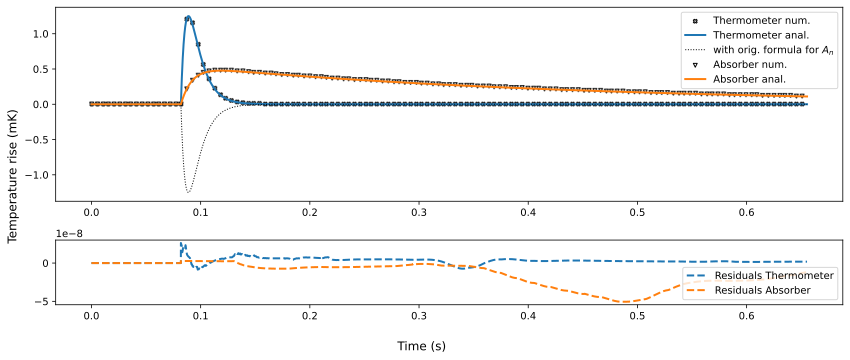

In [9]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12,5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax = [plt.subplot(gs[i]) for i in range(2)]

# fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True, dpi=300)

iv = int(record_window/128)

ax[0].scatter(t[::iv], Tp[::iv, 0], label='Thermometer num.', c='white', edgecolor='black', linewidth=1, rasterized=True, marker='X', s=15)
ax[0].plot(t, dTe_me, label='Thermometer anal.', c='C0', linewidth=2.)
ax[0].plot(t, dTe_Franz, label='with orig. formula for $A_n$', c='black', linewidth=1, linestyle='dotted')
ax[0].scatter(t[::iv], Tp[::iv, 1], label='Absorber num.', c='white', linewidth=1, edgecolor='black', rasterized=True, marker='v', s=15)
ax[0].plot(t, dTa_me, label='Absorber anal.', c='C1', linewidth=2.)
ax[0].legend(loc='upper right')

ax[1].plot(t, Tp[:, 0] - dTe_me, label='Residuals Thermometer', c='C0', linewidth=2, linestyle='dashed')
ax[1].plot(t, Tp[:, 1] - dTa_me, label='Residuals Absorber', c='C1', linewidth=2, linestyle='dashed')
ax[1].legend(loc='lower right')

fig.supxlabel('Time (s)')
fig.supylabel('Temperature rise (mK)')
plt.tight_layout()
plt.show()

In [10]:
import cryoenv.cryosig as cs

In [261]:
det = cs.DetectorModel(C=C, Gb=Gb, Tb=lambda x: 15., G=G, lamb=np.array([lamb, lamb]), 
                       eps=np.array([eps_, eps_]), dac=np.array([0.]))

In [262]:
det.set_control(dac=np.array([0.]), Ib=np.array([5.]))

In [264]:
det.wait(5)

In [265]:
det.trigger(er=np.array([0., 1.]), tpa=np.array([0.]))

T0 is [15.00001152 38.03999539] mK.
Calculated in 0.68436598777771 s.
Generated noise in 0.004511833190917969 s.


In [266]:
Tnum = det.get_temperatures()

In [267]:
Tanal = det.get_thermal_pulseshape(1.)

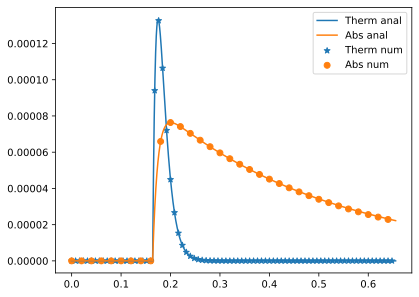

In [268]:
plt.plot(det.t, Tanal[0], label='Therm anal')
plt.plot(det.t, Tanal[1], label='Abs anal')
plt.scatter(det.t[::200], Tnum[::200,0] - np.mean(Tnum[:2000,0]), label='Therm num', marker='*')
plt.scatter(det.t[::500], Tnum[::500,1] - np.mean(Tnum[:2000,1]), label='Abs num', marker='o')
plt.legend()